In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

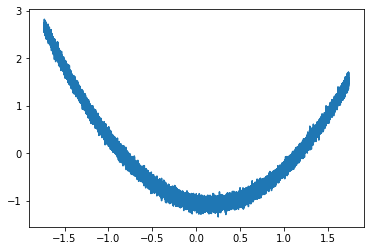

In [7]:
N = 50000
N = 50000
x_dim = 1
y_dim = 1
noise_std_true = 0.5
x = np.linspace(-10., 100., N)[None].T
x = np.float32(x)
b_true = np.random.randn(y_dim).astype(np.float32)   
w_true = np.random.randn(x_dim, y_dim).astype(np.float32) 

noise = noise_std_true * np.random.randn(N,y_dim).astype(np.float32)
y = np.matmul((x-50)**2, w_true)/100. + b_true + noise
x = x - np.mean(x)
x /= np.std(x)
y = y - np.mean(y)
y /= np.std(y)
plt.plot(x, y)

In [8]:
samples = np.hstack([x, y])

In [9]:
Dx = 2

In [10]:
def sample_batch(batch_size = 32):
    idx = np.random.randint(low = 0, high = 50000, size = batch_size)
    return samples[idx]

#### Define generator

In [11]:
z_dim = 10

In [20]:
generator = Sequential([
    Dense(200, 'relu', kernel_initializer='glorot_uniform', bias_initializer='ones',input_shape=(z_dim,)), 
    Dense(200, 'relu',kernel_initializer='glorot_uniform', bias_initializer='ones'), 
    Dense(Dx, 'relu', kernel_initializer='glorot_uniform', bias_initializer='ones')
])

#### Define discriminator

In [13]:
discriminator = Sequential([
    Dense(200, 'relu',kernel_initializer='glorot_uniform', bias_initializer='ones', input_shape=(Dx,)),
    Dense(200, 'relu',kernel_initializer='glorot_uniform', bias_initializer='ones',),
    Dense(1, 'relu',kernel_initializer='glorot_uniform', bias_initializer='ones',)
])

#### Define the training functions

In [14]:
optimizer_gen = tf.keras.optimizers.RMSprop(lr=0.00005)
optimizer_disc = tf.keras.optimizers.RMSprop(lr=0.00005)

/home/teguh/miniconda3/envs/tf3/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
from IPython.core import display


In [16]:
@tf.function
def train_discriminator(x_real, x_fake):
    n = x_real.shape[0]
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(discriminator.forward_pass(x_real)[0]- discriminator.forward_pass(x_fake)[0])
        
    gradients = tape.gradient(loss, discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients, discriminator.trainable_variables))
    for i, weights in enumerate(discriminator.trainable_variables):
        discriminator.trainable_variables[i].assign(tf.clip_by_value(weights, -0.01, 0.01))
    return loss, gradients

In [17]:
@tf.function
def train_generator(z):
    n = z.shape[0]
    with tf.GradientTape() as tape:
        x_fake = generator.forward_pass(z)[0]
        loss = - tf.reduce_mean(discriminator.forward_pass(x_fake)[0])
        
    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss, gradients

In [18]:
batch = 64

In [19]:
plotting = True
avgs_real = []
avgs_fake = []
for epoch in range(100000):
    try:
        if epoch < 25 or epoch % 500 == 0:
            n_critic = 100
        else:
            n_critic = 5

        #train discriminator
        for i in range(n_critic):
            x_real = sample_batch(batch)
            z = tf.random.normal((batch, z_dim))
            x_fake = generator.forward_pass(z)[0]
            loss_disc, grad_disc = train_discriminator(x_real, x_fake)

        #train generator
        z = tf.random.normal((batch, z_dim))
        loss_gen, grad_gen = train_generator(z)

        display.clear_output(wait=True)
        avg_real = discriminator.forward_pass(x_real)[0].numpy().mean()
        avg_fake = discriminator.forward_pass(x_fake)[0].numpy().mean()
        print("Epoch: {}, Avg real: {:.4f}, Avg fake: {:.4f}".format(epoch, avg_real, avg_fake))    

        avgs_real.append(avg_real)
        avgs_fake.append(avg_fake)

        if plotting and epoch % 100 == 0:
            plt.clf()
            fig,ax = plt.subplots()
            ax.plot(samples[:,0], samples[:,1], "k.")
            z = tf.random.normal((50000, z_dim))
            x_test = generator.forward_pass(z)[0]
            ax.plot(x_test[:,0], x_test[:,1], "b.", alpha=0.1)
            plt.axis('equal')
            plt.savefig('images/epoch{}'.format(epoch))
        
    except KeyboardInterrupt:
            break

AttributeError: 'Sequential' object has no attribute 'forward_pass'